Gaussian Process For Numerical Integration

By: Ryan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '1', 'grid.color': '1'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100


First we need to construct a function that we wish to find. This function will be used in order to create our noisy observations, but the true identity of the function will not be used. Below, the true function is shown in black, while the red data points will serve as our noisy observations. The goal of this mini project will be to find the integral as accurately as possible of the "true function" (black curve) while only being given the red data observations.

In order to create our sample data, we simply apply noise to the function at 101 evenly spaced intervals, where the noise comes from a Normal Distribution with a standard deviation of 0.4.

SIMULATING THE DATA

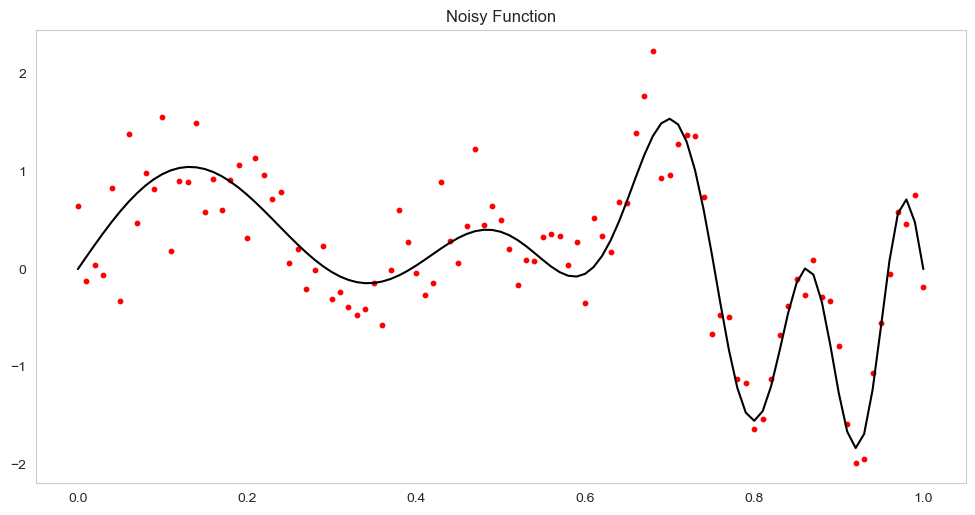

In [2]:
np.random.seed(1)

def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x**3)
    return(f)

n=101
x = np.linspace(start=0,stop=1,num=n)
f_x = f(x)

sigma_n = 0.4
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
y = f_x + epsilon


plt.plot(x,f_x,color='black')
plt.scatter(x,y,c='red',s=10)
plt.title('Noisy Function')
plt.show()

CONSTRUCTING THE GAUSSIAN PROCESS FROM SCRATCH

In [4]:
n_star = 501
n = 101

x_star = np.linspace(start=0, stop=1, num=n_star)
x = np.linspace(start=0, stop=1, num=n)

def exponential_kernel(x, y, sigma_f=1, l=1):
    
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

import itertools

def cov_matrices(x, x_star, sigma_f=1, l=1):

    K = [exponential_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [exponential_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [exponential_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

l = 1
sigma_f = 1

K, K_star2, K_star = cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

We can now use Cholesky Decomposition in order to speed up the matrix inversion process

In [5]:
sigma_n = 0.4
d = 1
n = 101

def parameters(K, K_star2, K_star, sigma_n):
    
    inv_K_plus = np.linalg.inv(np.linalg.cholesky(K + (sigma_n**2)*np.eye(n)))
    inverse_K_plus = np.dot(inv_K_plus.T,inv_K_plus)
    
    f_bar_star = np.dot(K_star, np.dot(inverse_K_plus, y.reshape([n, d])))

    cov_f_star = K_star2 - np.dot(K_star, np.dot(inverse_K_plus, K_star.T))
    
    return (f_bar_star, cov_f_star)

f_bar_star, cov_f_star = parameters(K, K_star2, K_star, sigma_n)

OPTIMIZING THE HYPERPARAMETERS

Now we will need to find specific sigma_f as well as l in order to full optimize our GP. The optimal values for these parameters can be found at the maximum of the log likelihood function, so all that needs to be done is see where the first derivative with respects to each of these parameters is equal to zero and there lies the optimal value of each parameter.

In [6]:
def kernel_function_sigma(x, y, sigma_f=sigma_f, l=l):
    kernel = np.exp(-(np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

def kernel_function_l(x, y, sigma_f=sigma_f, l=l):
    kernel = ((np.linalg.norm(x - y)**2) / (l**3)) * sigma_f * np.exp(-(np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

def Dk_Ds(x, l=l, sigma_f=sigma_f):
    dK_ds = [kernel_function_sigma(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]
    dK_ds = np.array(dK_ds).reshape(n, n) 
    return dK_ds

def Dk_Dl(x, l=l, sigma_f=sigma_f):
    dK_dl = [kernel_function_l(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]
    dK_dl = np.array(dK_dl).reshape(n, n) 
    return dK_dl

Our function that we are maximizing is very sensitive to small steps and our graphical space that that we are observing our data in is very small. Due to these facts, and since we are using the Gradient Ascent Method in order to maximize this function, we set our learning rate to be very small at 'a = 0.00001'.

In [19]:
sigma_n = 0.4
sigma_f = 0.5
l = 0.03

x_star = np.linspace(start=0, stop=1, num=n_star)
x = np.linspace(start=0, stop=1, num=n)
y = y

a = 0.00001

for i in range (0,50):
    K, K_star2, K_star = cov_matrices(x, x_star, sigma_f=sigma_f, l=l)
    K += (sigma_n**2)*np.eye(n)
    
    dK_ds = Dk_Ds(x, l=l, sigma_f=sigma_f)
    dK_dl = Dk_Dl(x, l=l, sigma_f=sigma_f)
    
    
    inv = np.linalg.inv(np.linalg.cholesky(K))
    inverse_K = np.dot(inv.T,inv)
    
    
    alpha = np.dot(inverse_K,y.reshape([n,d]))

    sigma_f = sigma_f + a*(0.5)*np.trace(np.dot((np.dot(alpha,alpha.T) - inverse_K),dK_ds))
    l = l + a*(0.5)*np.trace(np.dot((np.dot(alpha,alpha.T) - inverse_K),dK_dl))
    
    E1 = (0.5)*np.trace(np.dot((np.dot(alpha,alpha.T) - inverse_K),dK_ds))
    E2 = (0.5)*np.trace(np.dot((np.dot(alpha,alpha.T) - inverse_K),dK_dl))
    
print(sigma_f)
print(l)
print("First Derivative w.r.t. sigma is", E1)
print("First Derivative w.r.t. l is",E2)

0.5002134510159074
0.036062036284920385
First Derivative w.r.t. sigma is 0.5743383962578703
First Derivative w.r.t. l is 0.007205896437067594


Since our likelihood function is maximized (where the first derivative w.r.t. each parameter is zero) we can conclude that when sigma_f = 0.5002134510159074 and l = 0.036062036284920385 we have chosen acceptable parameters to model/describe the given data produced by our 'unknown function'. 

VISUALLY PLOTTING OUR MODEL

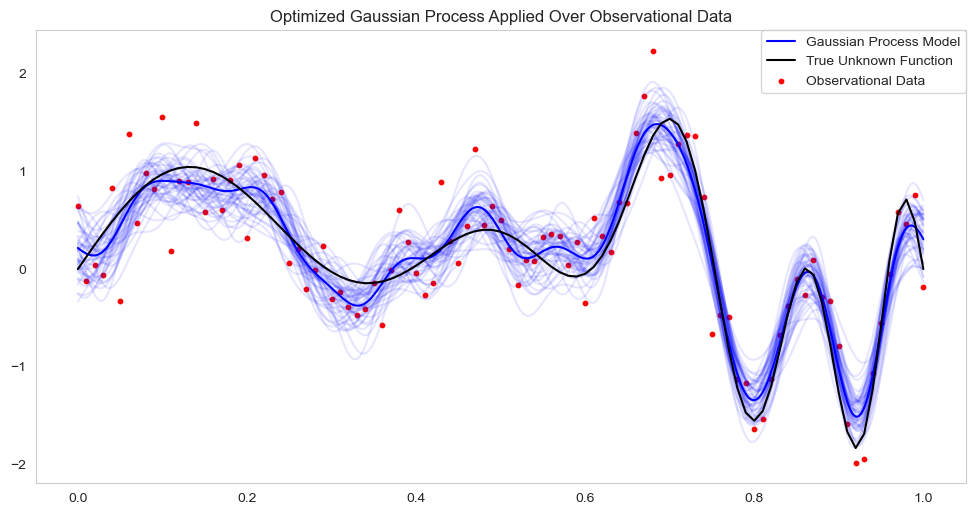

In [26]:
sigma_f = 0.5002134510159074
l = 0.036062036284920385
sigma_n = 0.4

n = 101
n_star = 501

x_star = np.linspace(start=0, stop=1, num=n_star)
x = np.linspace(start=0,stop=1,num=n)

K, K_star2, K_star = cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 50):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    m_star = f_bar_star.squeeze()
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.1, ax=ax)
    
plt.scatter(x, y, color='red', s=10, label='Observational Data')
plt.plot(x_star, m_star, color='blue', alpha=1, label='Gaussian Process Model')
plt.title("Optimized Gaussian Process Applied Over Observational Data")
plt.plot(x,f_x, color='black', label = 'True Unknown Function')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

plt.show()

Now we are finished modeling the dataset using the Gaussian Process. This statistical method for regression is really nice because it allows us to model a dataset without making strong underlying assumptions about where the data came from and what underlying trend it follows. For example, we could have easily used some type degree-n polynomial regression on this data set, but by doing so we would have to make an assumption about what degree polynomial function it is that this data came from. The Gaussian Process allows us to bypass this. 

INTEGRATING OVER THIS NEW FUNCTION

We can now utilize this Gaussian Process that we have created in order to perform numerical integration. We do this by using each of the 501 points that we have created to model the average path of the GP (dark blue line) that is used to model our true function (black line) and then perform the trapezoidal rule on these points. We can then compare this to the true area of the function and see just how accurate our approximation is.

In [40]:
from numpy import trapz

GP_area = trapz(m_star, dx=0.002)
true_area = trapz(f_x, dx=0.01)
y_area = trapz(y, dx=0.01)

print("Area from using our GP in combination with the Trapezoidal Rule =\n", GP_area)
print("Area from using the Trapezoidal Rule over our true function spaced 0.01 units apart at each point =\n", true_area)
print("Area from using the Trapezoidal Rule over our noisy observations =\n", y_area)

Area from using our GP in combination with the Trapezoidal Rule =
 0.1868017273756975
Area from using the Trapezoidal Rule over our true function spaced 0.01 units apart at each point =
 0.17393560050485643
Area from using the Trapezoidal Rule over our noisy observations =
 0.19402579347823742


We can see that our GP did a better job of approximating the area of our true function when compared to simply performing the Trapezoidal Rule on our noisy observations. Now we can look at the error the GP had versus the error of the noisy observations when compared to the true answer.

ERROR OBSERVATIONS

In [47]:
print("There is a",(abs(true_area-GP_area)/true_area)*100,"percent error using GP for Numerical Integration")
print("There is a",(abs(true_area-y_area)/true_area)*100,"percent error using noisy observations for Numerical Integration")

There is a 7.397063530120643 percent error using GP for Numerical Integration
There is a 11.55036284410336 percent error using noisy observations for Numerical Integration
